In [1]:
#
# Import needed packages
#
import numpy as np
import time
import pandas as pd
import csv
from numpy import genfromtxt
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

C:\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [2]:
#
# Read data
#
dataset = genfromtxt('../../data/realestate/realestate_condo.csv', delimiter=',')
dataset = dataset[1:,:]

ndata=dataset.shape[0]
nvar=dataset.shape[1]

X = dataset[:,0]
y = dataset[:,nvar-1]
nvar = 1

print('Number of data: %d \nNumber of variables: %d' % (ndata,nvar) )

Number of data: 2246 
Number of variables: 1


In [3]:
#
# normalize the data attributes
#
min_X = np.amin(X,axis=0)
max_X = np.amax(X,axis=0)
diff_X = max_X-min_X;
nrm_X = np.zeros((ndata,nvar))
for i in range(ndata):
    nrm_X[i] = (X[i]-min_X) / diff_X

In [4]:
#
# define parameters for cross-validation
#
nfold=5

minsigma=-3
maxsigma=2
nsigma=5

mincost=3
maxcost=8
ncost=5

cvsigma=np.logspace(minsigma, maxsigma, nsigma)
cvcost=np.logspace(mincost,maxcost,ncost)

In [5]:
#
# 5-fold cross-validation to define parameters
#
i=0
kf = KFold(ndata, n_folds=nfold, shuffle=True)
cvape=np.zeros((nsigma,ncost,nfold))
for train, test in kf:
    X_train=nrm_X[train]
    y_train=y[train]
    X_test=nrm_X[test]
    y_test=y[test]
    for j in range(nsigma):
        for k in range(ncost):
            print (" Working on: Fold=%10.4f, Sigma=%10.4f, Cost=%10.4f" % (i,cvsigma[j],cvcost[k]) )
            svr_rbf=SVR(kernel='rbf', C=cvcost[k], gamma=cvsigma[j])
            y_pred=svr_rbf.fit(X_train, y_train).predict(X_test)
            cvape[i,j,k] = np.mean ( np.abs((y_test - y_pred)/y_test) )
    i = i+1           
            

 Working on: Fold=    0.0000, Sigma=    0.0010, Cost= 1000.0000
 Working on: Fold=    0.0000, Sigma=    0.0010, Cost=17782.7941
 Working on: Fold=    0.0000, Sigma=    0.0010, Cost=316227.7660
 Working on: Fold=    0.0000, Sigma=    0.0010, Cost=5623413.2519
 Working on: Fold=    0.0000, Sigma=    0.0010, Cost=100000000.0000
 Working on: Fold=    0.0000, Sigma=    0.0178, Cost= 1000.0000
 Working on: Fold=    0.0000, Sigma=    0.0178, Cost=17782.7941
 Working on: Fold=    0.0000, Sigma=    0.0178, Cost=316227.7660
 Working on: Fold=    0.0000, Sigma=    0.0178, Cost=5623413.2519
 Working on: Fold=    0.0000, Sigma=    0.0178, Cost=100000000.0000
 Working on: Fold=    0.0000, Sigma=    0.3162, Cost= 1000.0000
 Working on: Fold=    0.0000, Sigma=    0.3162, Cost=17782.7941
 Working on: Fold=    0.0000, Sigma=    0.3162, Cost=316227.7660
 Working on: Fold=    0.0000, Sigma=    0.3162, Cost=5623413.2519
 Working on: Fold=    0.0000, Sigma=    0.3162, Cost=100000000.0000
 Working on: Fold= 

In [6]:
#
# Mean absolute percentage error
#
cvmape=np.mean(cvape,axis=0)

In [7]:
#
# Get indexes of parameter combination with minimum error
#
idxsigma, idxcost = np.unravel_index(cvmape.argmin(), cvmape.shape)

In [8]:
#
# Print out Results
#
optsigma=cvsigma[idxsigma];
optcost=cvcost[idxcost];
print("Best parameters: \n  Sigma = %10.4f\n  Cost = %10.4f\n  Relative Accuracy = %10.4f" % (cvsigma[idxsigma],cvcost[idxcost],cvmape[idxsigma,idxcost]))

Best parameters: 
  Sigma =     5.6234
  Cost = 316227.7660
  Relative Accuracy =     0.1473


C:\Anaconda3\lib\site-packages\matplotlib\figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


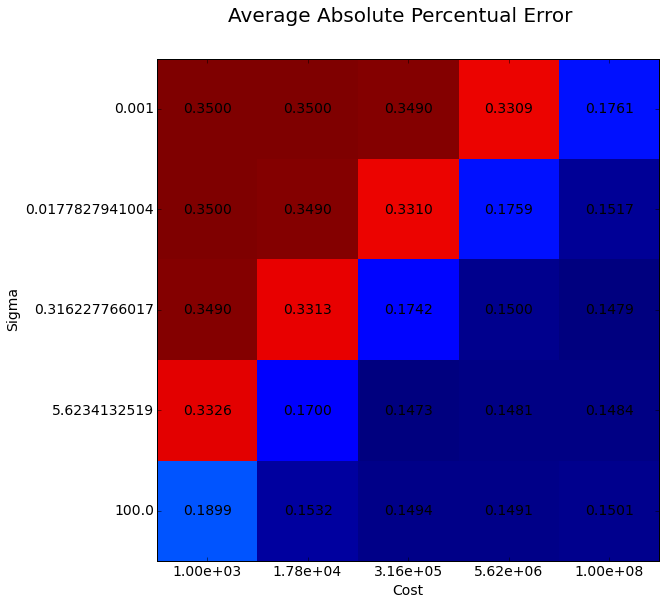

In [9]:
#
# Plot results for all combinations tested
#
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,figsize=(9,9))
ax.imshow(cvmape,interpolation='nearest')
for i in range(nsigma):
    for j in range(ncost):
        ax.text(i,j,("%.4f" % cvmape[j,i]), va='center', ha='center')
        
fig.suptitle('Average Absolute Percentual Error', fontsize=20)
plt.xlabel('Cost')
plt.ylabel('Sigma')

plt.xticks(range(ncost),np.char.mod('%.2e', cvcost))
plt.yticks(range(nsigma),cvsigma)

fig.show()

In [10]:
#
# Run in all data set with optimal parameters
#
svr_rbf=SVR(kernel='rbf', C=optcost, gamma=optsigma)
y_pred=svr_rbf.fit(nrm_X, y).predict(nrm_X)
trainmape = np.mean ( np.abs((y - y_pred)/y) )


In [11]:
#
# Report Results
#
print("Cross-Validation Accuracy: %10.4f\nTrain set Accuracy:        %10.4f" %(cvmape[idxsigma,idxcost],trainmape))

Cross-Validation Accuracy:     0.1473
Train set Accuracy:            0.1470


C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


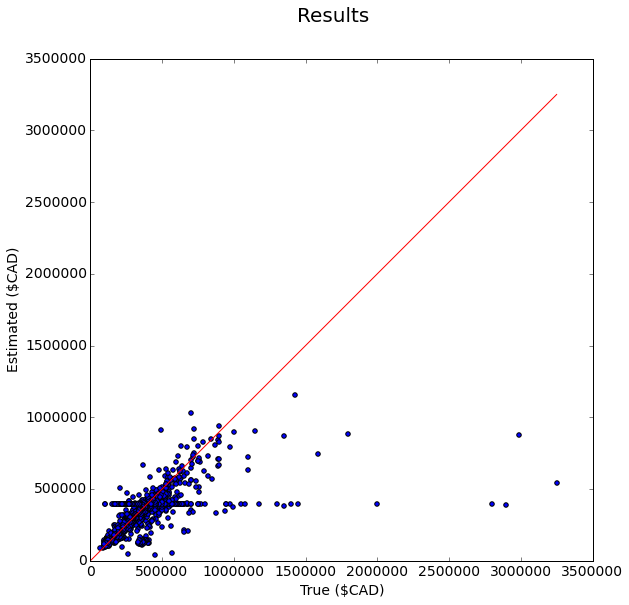

In [12]:
#
#
#
fig, ax = plt.subplots(1,figsize=(9,9))
ax.scatter(y,y_pred)
ax.plot([0, np.max(y)], [0, np.max(y)], color=[1,0,0])
axy=ax.get_ylim()
axx=ax.get_xlim()
plt.xlim(0,np.max([axx[1],axy[1]]))
plt.ylim(0,np.max([axx[1],axy[1]]))
fig.suptitle('Results', fontsize=20)
plt.xlabel('True ($CAD)')
plt.ylabel('Estimated ($CAD)')


C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


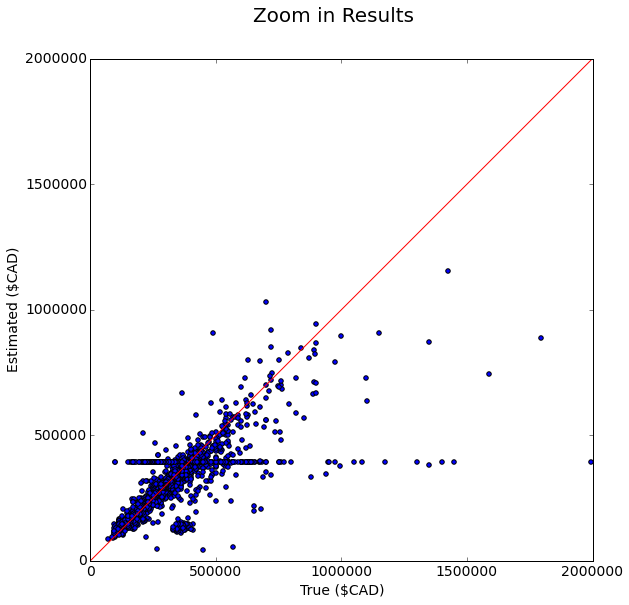

In [13]:
fig, ax = plt.subplots(1,figsize=(9,9))
ax.scatter(y,y_pred)
ax.plot([0, np.max(y)], [0, np.max(y)], color=[1,0,0])
axy=ax.get_ylim()
axx=ax.get_xlim()
plt.xlim(0,2000000)
plt.ylim(0,2000000)
fig.suptitle('Zoom in Results', fontsize=20)
plt.xlabel('True ($CAD)')
plt.ylabel('Estimated ($CAD)')